In [2]:
import xarray as xr
import numpy as np
import gdal

In [3]:
ds = xr.open_dataset("C:\\Users\gunnar\src\data\dcs4cop\VITO\S2_0001_NS_20170720T105026Z_31UET_v006.nc")

In [4]:
ds

<xarray.Dataset>
Dimensions:                       (x: 10980, y: 10980)
Coordinates:
  * x                             (x) float64 5e+05 5e+05 5e+05 5e+05 5e+05 ...
  * y                             (y) float64 5.8e+06 5.8e+06 5.8e+06 ...
    lon                           (y, x) float64 ...
    lat                           (y, x) float64 ...
Data variables:
    transverse_mercator           int32 ...
    Ltoa_1610                     (y, x) float32 ...
    Ltoa_2190                     (y, x) float32 ...
    rrs_443                       (y, x) float32 ...
    rrs_490                       (y, x) float32 ...
    rrs_560                       (y, x) float32 ...
    rrs_665                       (y, x) float32 ...
    rrs_705                       (y, x) float32 ...
    rrs_740                       (y, x) float32 ...
    rrs_783                       (y, x) float32 ...
    rrs_842                       (y, x) float32 ...
    rrs_865                       (y, x) float32 ...
    TUR_NECH

In [5]:
ds.x

<xarray.DataArray 'x' (x: 10980)>
array([ 499985.,  499995.,  500005., ...,  609755.,  609765.,  609775.])
Coordinates:
  * x        (x) float64 5e+05 5e+05 5e+05 5e+05 5e+05 5e+05 5e+05 5.001e+05 ...
Attributes:
    units:          m
    standard_name:  projection_x_coordinate

In [6]:
ds.Kd_560

<xarray.DataArray 'Kd_560' (y: 10980, x: 10980)>
[120560400 values with dtype=float32]
Coordinates:
  * x        (x) float64 5e+05 5e+05 5e+05 5e+05 5e+05 5e+05 5e+05 5.001e+05 ...
  * y        (y) float64 5.8e+06 5.8e+06 5.8e+06 5.8e+06 5.8e+06 5.8e+06 ...
    lon      (y, x) float64 ...
    lat      (y, x) float64 ...
Attributes:
    standard_name:  diffuse_attenuation_coefficient_of_downwelling_radiative_...
    long_name:      Diffuse attenuation coefficient at 560 nm, KD2 algorithm
    units:          m-1
    valid_min:      50.0
    valid_max:      30000.0
    grid_mapping:   transverse_mercator

In [7]:
ds.Kd_560.encoding

{'zlib': True,
 'shuffle': True,
 'complevel': 4,
 'fletcher32': False,
 'contiguous': False,
 'chunksizes': (999, 999),
 'least_significant_digit': 5,
 'source': 'C:\\Users\\gunnar\\src\\data\\dcs4cop\\VITO\\S2_0001_NS_20170720T105026Z_31UET_v006.nc',
 'original_shape': (10980, 10980),
 'dtype': dtype('float32'),
 '_FillValue': nan,
 'coordinates': 'lat lon'}

In [8]:
ds.Kd_560.plot.imshow(vmin=0., vmax=.5)

In [9]:
CRS_WKT_EPSG_4326 = """
GEOGCS["WGS 84",
    DATUM["WGS_1984",
        SPHEROID["WGS 84",6378137,298.257223563,
            AUTHORITY["EPSG","7030"]],
        AUTHORITY["EPSG","6326"]],
    PRIMEM["Greenwich",0,
        AUTHORITY["EPSG","8901"]],
    UNIT["degree",0.01745329251994328,
        AUTHORITY["EPSG","9122"]],
    AUTHORITY["EPSG","4326"]]
"""

In [10]:
ds.transverse_mercator

<xarray.DataArray 'transverse_mercator' ()>
array(-2147483647)
Attributes:
    grid_mapping_name:                 transverse_mercator
    scale_factor_at_central_meridian:  0.9996
    longitude_of_central_meridian:     3.0
    latitude_of_projection_origin:     0.0
    false_easting:                     500000.0
    false_northing:                    0.0
    semi_major_axis:                   6378137.0
    inverse_flattening:                298.257223563

In [11]:
CRS_WKT_S2 = """
PROJCS["Some Sentinel-2 UTM Tile",
    GEOGCS["WGS 84",
        DATUM["WGS_1984",
            SPHEROID["WGS 84",6378137,298.257223563,
                AUTHORITY["EPSG",7030]],
            TOWGS84[0,0,0,0,0,0,0],
            AUTHORITY["EPSG",6326]],
        PRIMEM["Greenwich",0,AUTHORITY["EPSG",8901]],
        UNIT["DMSH",0.0174532925199433,AUTHORITY["EPSG",9108]],
        AXIS["Lat",NORTH],
        AXIS["Long",EAST],
        AUTHORITY["EPSG",4326]],
    PROJECTION["Transverse_Mercator"],
    PARAMETER["latitude_of_origin",0.0],
    PARAMETER["central_meridian",3.0],
    PARAMETER["scale_factor",0.9996],
    PARAMETER["false_easting",500000.0],
    PARAMETER["false_northing",0.0]]
"""

In [12]:
ds.x.values

array([ 499985.,  499995.,  500005., ...,  609755.,  609765.,  609775.])

In [13]:
ds.y.values

array([ 5800015.,  5800005.,  5799995., ...,  5690245.,  5690235.,
        5690225.])

See http://www.gdal.org/structGDALWarpOptions.html

In [14]:
def reproject_to_wgs84(src_var):
    src_width = src_var.shape[-1]
    src_height = src_var.shape[-2]
    
    src_x1 = float(src_var.x[0])
    src_x2 = float(src_var.x[-1])
    src_y1 = float(src_var.y[0])
    src_y2 = float(src_var.y[-1])
    src_res = (src_x2 - src_x1) / (src_width - 1)
    src_geo_transform = (src_x1, src_res, 0.0,
                         src_y2, 0.0, -src_res)
    
    mem_driver = gdal.GetDriverByName("MEM")
    src_ds = mem_driver.Create('src_' + src_var.name, src_width, src_height, 1, gdal.GDT_Float32, [])    
    src_ds.SetProjection(CRS_WKT_S2)
    src_ds.SetGeoTransform(src_geo_transform)
    src_ds.GetRasterBand(1).SetNoDataValue(float('nan'))
    src_ds.GetRasterBand(1).WriteArray(src_var.values)

    dst_x1_0 = float(src_var.lon[0][0])
    dst_x2_0 = float(src_var.lon[0][-1])
    dst_y1_0 = float(src_var.lat[0][0])
    dst_y2_0 = float(src_var.lat[-1][0])
    dst_x1 = min(dst_x1_0, dst_x2_0)
    dst_x2 = max(dst_x1_0, dst_x2_0)
    dst_y1 = min(dst_y1_0, dst_y2_0)
    dst_y2 = max(dst_y1_0, dst_y2_0)
    print(dst_x1, dst_x2, dst_y1, dst_y2)
    dst_res_x = (dst_x2 - dst_x1) / (src_width - 1)
    dst_res_y = (dst_y2 - dst_y1) / (src_height - 1)    
    dst_res = min(dst_res_x, dst_res_y)
    dst_res *= 10  # !!!!
    print(dst_res_x, dst_res_y, dst_y1, dst_res)
    dst_width = int((dst_x2 - dst_x1) / dst_res + 0.5)
    dst_res = (dst_x2 - dst_x1) / dst_width
    dst_height = int((dst_y2 - dst_y1) / dst_res + 0.5)    
    print(dst_width, dst_height, dst_res)
    dst_geo_transform = (dst_x1 - dst_res / 2, dst_res, 0.0,
                         dst_y1 - dst_res / 2, 0.0, -dst_res)
    print(dst_geo_transform)
    # correct actual
    dst_x2 = dst_x1 + dst_res * (dst_width - 1)
    dst_y2 = dst_y1 + dst_res * (dst_height - 1)

    dst_ds = mem_driver.Create('dst_' + src_var.name, dst_width, dst_height, 1, gdal.GDT_Float32, [])
    dst_ds.SetProjection(CRS_WKT_EPSG_4326)
    dst_ds.SetGeoTransform(dst_geo_transform)
    dst_ds.GetRasterBand(1).SetNoDataValue(float('nan'))

    resample_alg = gdal.GRA_NearestNeighbour
    warp_mem_limit = 0
    error_threshold = 0
    options = ['INIT_DEST=NO_DATA']
    gdal.ReprojectImage(src_ds,
                        dst_ds,
                        None, # src_wkt
                        None, # dst_wkt
                        resample_alg,
                        warp_mem_limit,
                        error_threshold,
                        None,  # callback,
                        None,  # callback_data,
                        options)
    
    dst_values = dst_ds.GetRasterBand(1).ReadAsArray()
    
    dst_var = xr.DataArray(dst_values, 
                           dims=['lat', 'lon'], 
                           name=src_var.name, 
                           attrs=dict(**src_var.attrs), 
                           coords=dict(lat=np.linspace(dst_y1, dst_y2 + dst_res, dst_height),
                                       lon=np.linspace(dst_x1, dst_x2 + dst_res, dst_width)))
    
    return dst_var

In [15]:
kd_560_proj = reproject_to_wgs84(ds.Kd_560)

2.999779775738716 4.6113093718886375 51.363286666572094 52.35042820125818
0.00014678291248291478 8.991178929648315e-05 51.363286666572094 0.0008991178929648315
1792 1098 0.0008992910692800901
(2.999330130204076, 0.0008992910692800901, 0.0, 51.36283702103746, 0.0, -0.0008992910692800901)


In [16]:
kd_560_proj

<xarray.DataArray 'Kd_560' (lat: 1098, lon: 1792)>
array([[ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       ..., 
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan]], dtype=float32)
Coordinates:
  * lat      (lat) float64 51.36 51.36 51.37 51.37 51.37 51.37 51.37 51.37 ...
  * lon      (lon) float64 3.0 3.001 3.002 3.002 3.003 3.004 3.005 3.006 ...
Attributes:
    standard_name:  diffuse_attenuation_coefficient_of_downwelling_radiative_...
    long_name:      Diffuse attenuation coefficient at 560 nm, KD2 algorithm
    units:          m-1
    valid_min:      50.0
    valid_max:      30000.0
    grid_mapping:   transverse_mercator

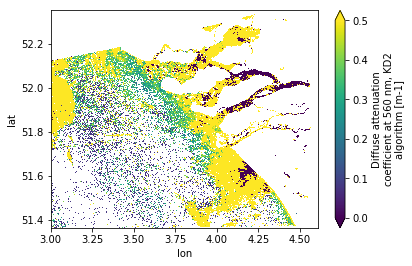

In [17]:
kd_560_proj.plot.imshow(vmin=0., vmax=.5)